In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import math
import os

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error

#from keras.losses import mean_squared_error, root_mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, concatenate, Input
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop
from pickle import load

In [2]:
seq_len = 48
pred_t = 1
batch = 32

In [3]:
train_set_ASOS = np.load('seq_data/refined_seq_data_ASOS.npy', allow_pickle=True)
train_target = np.load('seq_data/refined_train_target.npy', allow_pickle=True)

test_set1 = np.load('seq_data/seq_test20_ASOS.npy', allow_pickle=True)
test_set2 = np.load('seq_data/seq_test21_ASOS.npy', allow_pickle=True)
test_set3 = np.load('seq_data/seq_test22_ASOS.npy', allow_pickle=True)

test_target1 = np.load('seq_data/seq_test20_target.npy', allow_pickle=True)
test_target2 = np.load('seq_data/seq_test21_target.npy', allow_pickle=True)
test_target3 = np.load('seq_data/seq_test22_target.npy', allow_pickle=True)

splited_train, val_train, splited_target, val_target = train_test_split(
    train_set_ASOS, train_target, test_size = 0.2, random_state = 100)

In [4]:
model_ASOS = Sequential()
model_ASOS.add(LSTM(units = 128, activation = 'tanh',
                 input_shape = (seq_len, 16) ))
model_ASOS.add(Dropout(0.2))
model_ASOS.add(Dense(units = 128, activation = 'relu'
                          ))
model_ASOS.add(Dropout(0.2))
model_ASOS.add(Dense(1, activation = 'linear'
                          ))
opt = Adam(learning_rate= 0.0001)
model_ASOS.compile(loss = 'mean_absolute_error', optimizer = opt)
model_ASOS.summary()

checkpoint_cb = keras.callbacks.ModelCheckpoint('modeling_data/best_of_ASOS.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)

history = model_ASOS.fit(splited_train, splited_target,
                      validation_data = (val_train, val_target), 
                      epochs = 500, batch_size = batch, 
                      callbacks = [checkpoint_cb, early_stopping_cb], 
                      verbose = 2)

print('best epochs is', early_stopping_cb.stopped_epoch)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               74240     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 90,881
Trainable params: 90,881
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
900/900 - 9s - loss: 0.2013 - val_loss: 

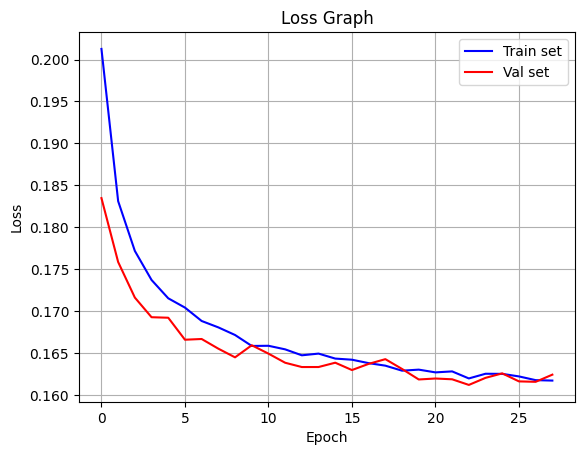

In [5]:
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_loss, c = 'blue', label="Train set")
plt.plot(x_len, y_vloss, c = 'red', label="Val set")

plt.legend(loc='upper right')
plt.grid()
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [6]:
# y_mae = history.history['mae']
# y_vmae = history.history['val_mae']
# plt.plot(x_len, y_mae, c = 'blue', label = "Train set")
# plt.plot(x_len, y_vmae, c = 'red', label = "Val set")

# plt.legend(loc='upper right')
# plt.grid()
# plt.title('MAE Graph')
# plt.xlabel('Epoch')
# plt.ylabel('MAE')
# plt.show()

In [7]:
# Train set predict
pred_train_target = model_ASOS.predict(splited_train, batch_size = batch)
obsv_train_target = splited_target

900/900 [==============================] - 2s 2ms/step


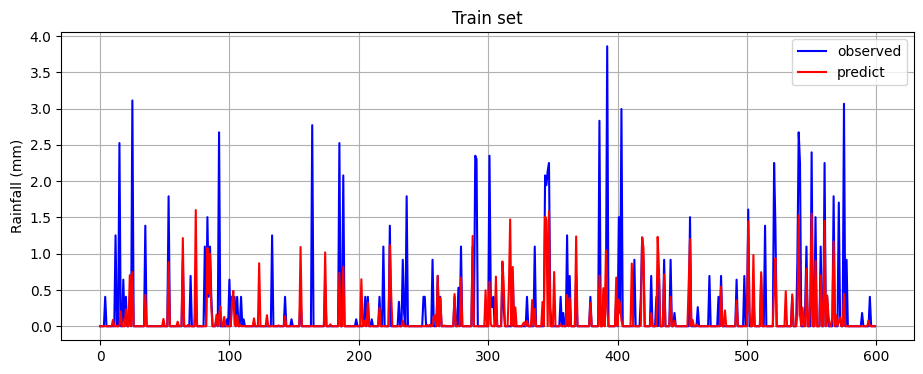

225/225 [==============================] - 1s 2ms/step


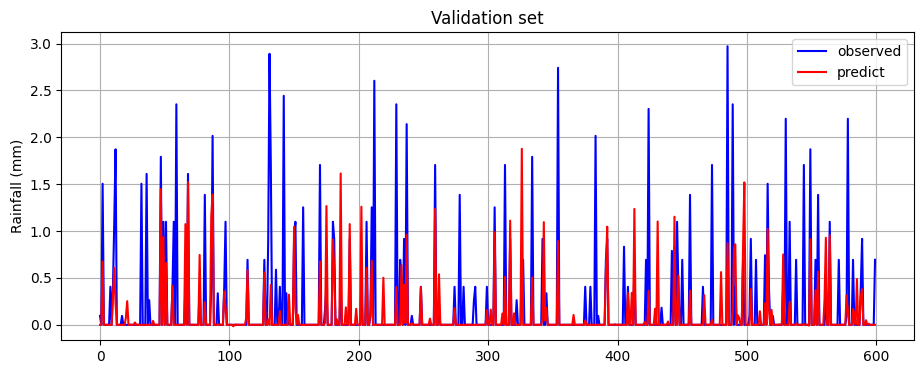

In [8]:
index_train = np.arange(38205)
a1 = range(0, 600)
a2 = range(0, 600)


plt.figure(figsize = (11, 4))
plt.plot(index_train[a1], obsv_train_target[a1], 'b', label = 'observed')
plt.plot(index_train[a1], pred_train_target[a1], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Train set')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

pred_val_target = model_ASOS.predict(val_train, batch_size = batch)
obsv_val_target = val_target

plt.figure(figsize = (11, 4))
plt.plot(index_train[a2], obsv_val_target[a2], 'b', label = 'observed')
plt.plot(index_train[a2], pred_val_target[a2], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Validation set')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

In [9]:
print(pred_train_target)
print(pred_train_target.shape)

[[-8.3406894e-07]
 [-8.3406894e-07]
 [-8.3406894e-07]
 ...
 [-8.3406894e-07]
 [ 1.0236596e-01]
 [ 4.9186024e-01]]
(28772, 1)


In [10]:
# Test1 predict
pred_test_target1 = model_ASOS.predict(test_set1, batch_size = batch)
obsv_test_target1 = test_target1

# Test2 predict
pred_test_target2 = model_ASOS.predict(test_set2, batch_size = batch)
obsv_test_target2 = test_target2

# Test3 predict
pred_test_target3 = model_ASOS.predict(test_set3, batch_size = batch)
obsv_test_target3 = test_target3

137/137 [==============================] - 0s 2ms/step


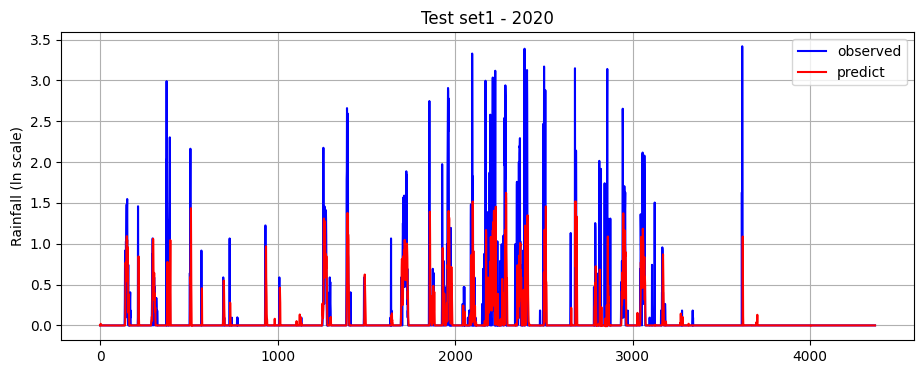

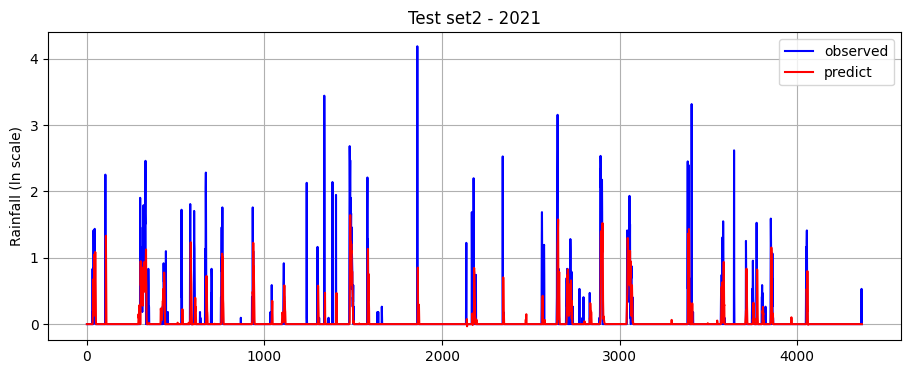

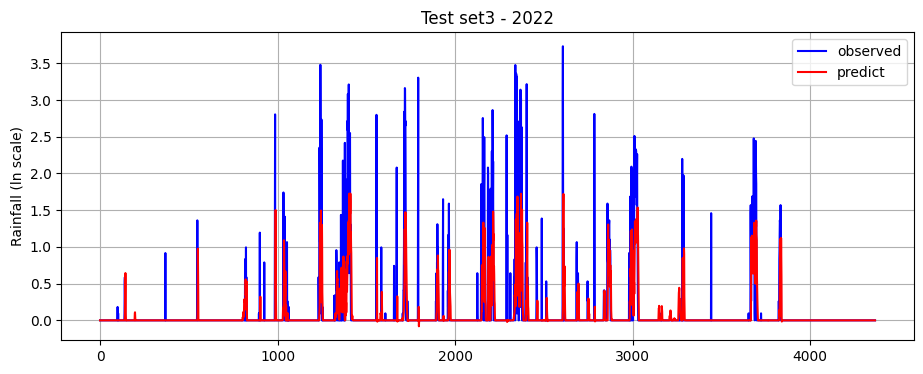

In [12]:
# graph of test1 (ln scale)

index_test = np.arange(4366)
b1 = range(0, 4366)
b2 = range(0, 4366)
b3 = range(0, 4366)

plt.figure(figsize = (11, 4))
plt.plot(index_test[b1], obsv_test_target1[b1], 'b', label = 'observed')
plt.plot(index_test[b1], pred_test_target1[b1], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set1 - 2020')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

# graph of test2

plt.figure(figsize = (11, 4))
plt.plot(index_test[b2], obsv_test_target2[b2], 'b', label = 'observed')
plt.plot(index_test[b2], pred_test_target2[b2], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set2 - 2021')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

# graph of test3

plt.figure(figsize = (11, 4))
plt.plot(index_test[b3], obsv_test_target3[b3], 'b', label = 'observed')
plt.plot(index_test[b3], pred_test_target3[b3], 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set3 - 2022')
plt.xlabel('\n')
plt.ylabel('Rainfall (ln scale)')
plt.show()

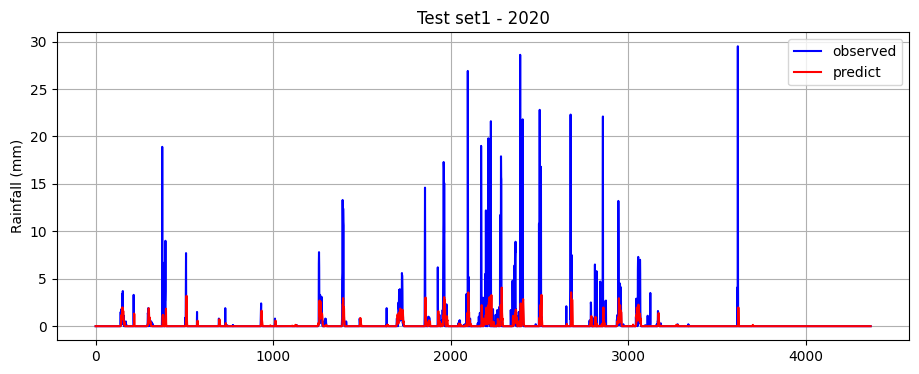

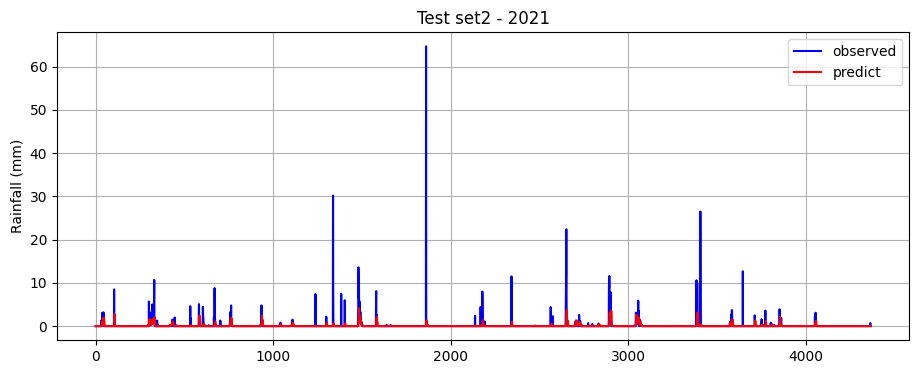

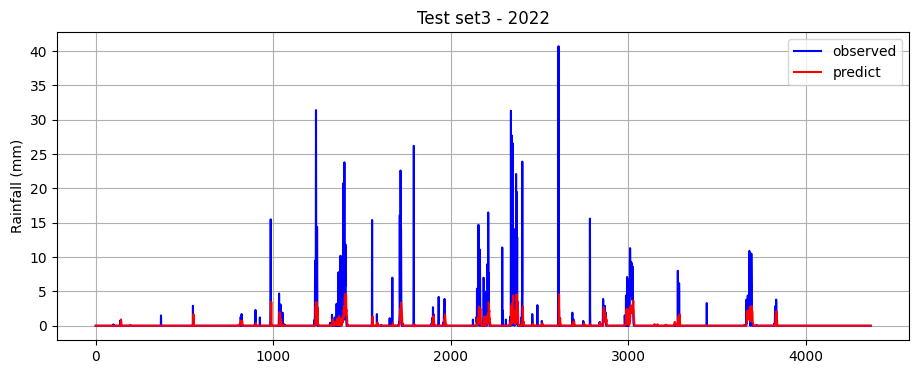

In [13]:
# graph of test1 (mm)

index_test = np.arange(4366)
b1 = range(0, 4366)
b2 = range(0, 4366)
b3 = range(0, 4366)

plt.figure(figsize = (11, 4))
plt.plot(index_test[b1], np.power(math.exp(1), obsv_test_target1[b1]) - 1, 'b', label = 'observed')
plt.plot(index_test[b1], np.power(math.exp(1), pred_test_target1[b1]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set1 - 2020')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

# graph of test2

plt.figure(figsize = (11, 4))
plt.plot(index_test[b2], np.power(math.exp(1), obsv_test_target2[b2]) - 1, 'b', label = 'observed')
plt.plot(index_test[b2], np.power(math.exp(1), pred_test_target2[b2]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set2 - 2021')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

# graph of test3

plt.figure(figsize = (11, 4))
plt.plot(index_test[b3], np.power(math.exp(1), obsv_test_target3[b3]) - 1, 'b', label = 'observed')
plt.plot(index_test[b3], np.power(math.exp(1), pred_test_target3[b3]) - 1, 'r', label = 'predict')

plt.legend(loc='upper right')
plt.grid()
plt.title('Test set3 - 2022')
plt.xlabel('\n')
plt.ylabel('Rainfall (mm)')
plt.show()

In [ ]:
np.save('modeling_data/ASOS_pred_test1', pred_test_target1)
np.save('modeling_data/ASOS_pred_test2', pred_test_target2)
np.save('modeling_data/ASOS_pred_test3', pred_test_target3)